In [1]:
import os
import random
import time

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from Physics_Engine import gen, make_video

USE_CUDA = True

In [2]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation

from matplotlib import rc
rc('animation', html='jshtml')
rc('animation', embed_limit = 22000000)

%matplotlib inline

<h3>N body</h3>
<p>In the n-body domain,  such as solar systems,  all
n
bodies exert distance- and mass-dependent
gravitational forces on each other, so there were
n
(
n
−
1)
relations input to our model.  Across
simulations, the objects’ masses varied, while all other fixed attributes were held consta</p>

In [3]:
n_objects  = 3 # number of planets(nodes)
object_dim = 5 # features: mass, x coordinate, y coordinate, speed on x-axis, speed on y-axis

n_relations  = n_objects * (n_objects - 1) # number of edges in fully connected graph
relation_dim = 1

effect_dim = 100 #effect's vector size

nb_scenes = 1000

Generating dataset of solar system dynamics for 1000 timesteps

In [4]:
data_scenes = []

In [5]:
data = gen(n_objects, True)


In [6]:
print(data.shape) # 1000 timesteps, n_objects, 5 featues - mass, x, y, speed_x, speed_y

(1000, 3, 5)


<h3>Batch</h3>

In [7]:
def get_batch(data, batch_size, i = False):
    if not i:
        #nb_s, nb_t, _, _ = data.shape 
        #rand_s = [random.randint(0, nb_s) for _ in range(batch_size)]
        rand_idx  = [random.randint(0, len(data) - 2) for _ in range(batch_size)]
        label_idx = [idx + 1 for idx in rand_idx]
    else:
        rand_s = [0]
        rand_idx = [0]
        label_idx = [0]
    
    #print(data.shape)
    
    #batch_data = data[rand_s][rand_idx]
    #label_data = data[rand_s][label_idx]
    batch_data = data[rand_idx]
    label_data = data[label_idx]
    
    objects = batch_data[:,:,:5]
    
    
    #receiver_relations, sender_relations - onehot encoding matrices
    #each column indicates the receiver and sender object’s index
    
    receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    
    cnt = 0
    for i in range(n_objects):
        for j in range(n_objects):
            if(i != j):
                receiver_relations[:, i, cnt] = 1.0
                sender_relations[:, j, cnt]   = 1.0
                cnt += 1
    
    #There is no relation info in solar system task, just fill with zeros
    relation_info = np.zeros((batch_size, n_relations, relation_dim))
    target = label_data[:,:,3:]
    #print(label_data.shape)
    #print(target.shape)
    
    objects            = Variable(torch.FloatTensor(objects))
    sender_relations   = Variable(torch.FloatTensor(sender_relations))
    receiver_relations = Variable(torch.FloatTensor(receiver_relations))
    relation_info      = Variable(torch.FloatTensor(relation_info))
    target             = Variable(torch.FloatTensor(target)).view(-1, 2)
                       
    if USE_CUDA:
        objects            = objects.cuda()
        sender_relations   = sender_relations.cuda()
        receiver_relations = receiver_relations.cuda()
        relation_info      = relation_info.cuda()
        target             = target.cuda()
    
    #print(target.shape)
    
    return objects, sender_relations, receiver_relations, relation_info, target

<h3>Relation-centric Nerural Network</h3>
<p>This NN takes all information about relations in the graph and outputs effects of all interactions between objects.
</p>

In [8]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        batch_size, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.layers(x)
        x = x.view(batch_size, n_relations, self.output_size)
        return x

<h3>Object-centric Neural Network</h3>
<p>This NN takes information about all objects and effects on them, then outputs prediction of the next state of the graph.</p>

In [9]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2), #mass, x, y, speedX and speedY
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size * n_objects, 2] speedX and speedY
        '''
        input_size = x.size(2)
        x = x.view(-1, input_size)
        return self.layers(x)

<h3>Interaction Network</h3>
<p>IN involves only matrix operations that do not contain learnable parameters.</p>

In [10]:
class InteractionNetwork(nn.Module):
    def __init__(self, n_objects, object_dim, n_relations, relation_dim, effect_dim):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model = RelationalModel(2*object_dim + relation_dim, effect_dim, 150)
        self.object_model     = ObjectModel(object_dim + effect_dim, 100)
    
    def forward(self, objects, sender_relations, receiver_relations, relation_info):
        senders   = sender_relations.permute(0, 2, 1).bmm(objects)
        receivers = receiver_relations.permute(0, 2, 1).bmm(objects)
        effects = self.relational_model(torch.cat([senders, receivers, relation_info], 2))
        effect_receivers = receiver_relations.bmm(effects)
        predicted = self.object_model(torch.cat([objects, effect_receivers], 2))
        return predicted

In [11]:
interaction_network = InteractionNetwork(n_objects, object_dim, n_relations, relation_dim, effect_dim)

if USE_CUDA:
    interaction_network = interaction_network.cuda()
    
optimizer = optim.Adam(interaction_network.parameters())
criterion = nn.MSELoss()

<h3>Training</h3>

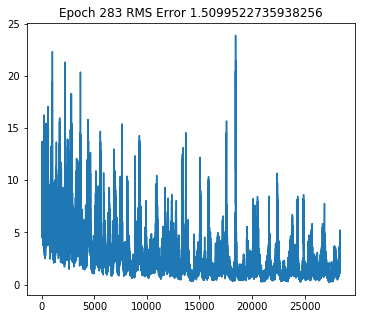

2.84


In [ ]:
n_epoch = 10000
batches_per_epoch = 100

losses = []

for epoch in range(n_epoch):
    for _ in range(batches_per_epoch):
        objects, sender_relations, receiver_relations, relation_info, target = get_batch(data, 30)
        predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
        #print(predicted.shape)
        #print(target.shape)
        
        loss = criterion(predicted, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(np.sqrt(loss.data.item()))

    print(100*epoch/n_epoch)
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s RMS Error %s' % (epoch, np.sqrt(np.mean(losses[-100:]))))
    plt.plot(losses)
    plt.show()

In [ ]:
from copy import deepcopy
def build_prediction_old(IN, init_state):
    out_data = [init_state]
    cur_data = init_state
    error = []
    for i in range(29):
        objects, sender_relations, receiver_relations, relation_info, target = get_batch(cur_data, 1, True)
        predicted = IN(objects, sender_relations, receiver_relations, relation_info)
        print(predicted.shape)
        #print(torch.tensor([data[i]]).shape)
        #loss = criterion(predicted, data[i])
        #error.append(np.sqrt(loss.data.item()))
        predicted = predicted.cpu().detach().numpy().reshape(1, 3, 5)
        out_data.append(predicted)
        cur_data = predicted
    #plt.plot(error)
    #plt.show()
    return np.array(out_data)

def bp(IN, init_state):
    out_data = [init_state]
    cur_data = init_state
    error = []
    for i in range(999):
        objects, sender_relations, receiver_relations, relation_info, target = get_batch(cur_data, 1, True)
        predicted_velocities = IN(objects, sender_relations, receiver_relations, relation_info)
        #print(predicted_velocities.shape)
        predicted_velocities = predicted_velocities.cpu().detach().numpy().reshape(1, 3, 2)
        #target = data[i, :, 3:]
        #target = Variable(torch.FloatTensor(target)).view(-1, 2)
        #loss = criterion(predicted_velocities, target)
        #error.append(np.sqrt(loss))
        cur_data[:, :, 3:] = predicted_velocities
        cur_data[:, :, 1:3] = cur_data[:, :, 1:3] + predicted_velocities*0.001
        out_data.append(deepcopy(cur_data))
    #plt.plot(error)
    #plt.show()
    return np.array(out_data)

In [ ]:
ani = make_video(data, 'theoretical.mp4')

In [ ]:
ani

In [ ]:
pred = bp(interaction_network, np.array([data[0, :, :]]))
print(pred.shape)
pred = pred.reshape(-1, 3, 5)
print(pred.shape)

In [ ]:
ani2 = make_video(pred, 'predicted.mp4')

In [ ]:
ani2